In [1]:
#import libraries
import pandas as pd
import numpy as np

import re
import string

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#Load the dataset and preprocess
df = pd.read_csv(r"C:\Users\USER\Downloads\amazonreviews.tsv", sep='\t')
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [4]:
#Remove Missing & Duplicate Reviews
df.dropna(subset=['review'], inplace=True)
df.drop_duplicates(subset=['review'], inplace=True)

In [5]:
#Convert Labels to Numeric
df['label'] = df['label'].map({'pos': 1, 'neg': 0})


In [7]:
#Text Preprocessing Function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)               # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

In [8]:
df['clean_review'] = df['review'].apply(clean_text)

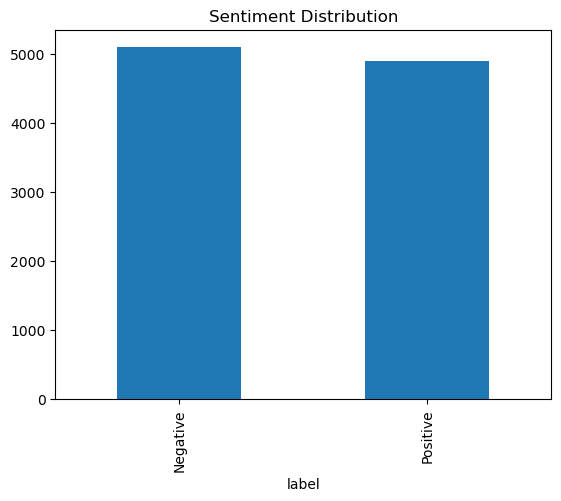

In [9]:
#EDA
df['label'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Negative', 'Positive'])
plt.title("Sentiment Distribution")
plt.show()


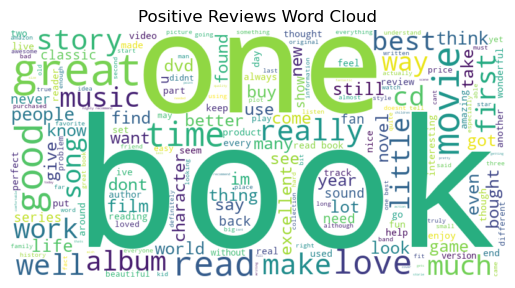

In [10]:
#Positive Reviews
positive_text = " ".join(df[df['label'] == 1]['clean_review'])

wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews Word Cloud")
plt.show()

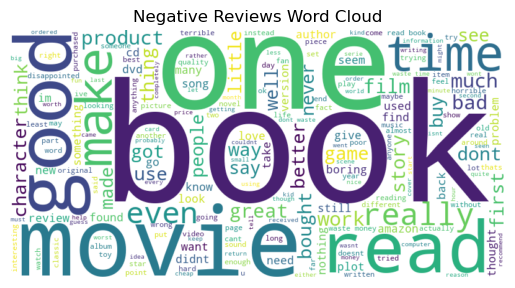

In [11]:
#Negative Reviews
negative_text = " ".join(df[df['label'] == 0]['clean_review'])

wc_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews Word Cloud")
plt.show()


In [12]:
# Feature Engineering (TF-IDF)
X = df['clean_review']
y = df['label']

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

In [13]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5000), (2000, 5000), (8000,), (2000,))

In [14]:
#Model training
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [15]:
#Model Evaluation
y_pred = model.predict(X_test)


In [16]:
#Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


Accuracy: 0.8555
F1 Score: 0.8529262086513995

Classification Report:

              precision    recall  f1-score   support

    Negative       0.86      0.86      0.86      1019
    Positive       0.85      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



In [17]:
#Cross validation
cv_f1 = cross_val_score(
    model, X_tfidf, y, cv=5, scoring='f1'
)

print("Cross-Validation F1 Scores:", cv_f1)
print("Mean CV F1 Score:", cv_f1.mean())


Cross-Validation F1 Scores: [0.8594622  0.82966752 0.82488238 0.83756345 0.85250887]
Mean CV F1 Score: 0.8408168852636478


In [21]:
#Predict
def predict_sentiment(review):
    review_cleaned = clean_text(review)
    review_tfidf = tfidf.transform([review_cleaned])
    prediction = model.predict(review_tfidf)[0]
    return "Positive" if prediction == 1 else "Negative"

predict_sentiment("I love this product")

'Positive'

### Conclusion